# RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда
нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое,
чтобы можно было обучить хорошую стратегию методами TD-обучения или другими
методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том
числе и достаточно техническое, так что для решения придётся немножко
попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук
на вашем github (или публичный, или с доступом для snikolenko); ссылку
обязательно нужно прислать в виде сданного домашнего задания на портале
Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда,
категорически приветствуются.

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая
реализована в OpenAI Gym:

* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для
валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит
21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко,
если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
    * hit — взять ещё одну карту;
    * stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока
сумма карт в его руке меньше 17;
*  после этого игрок выигрывает, если дилер либо превышает 21, либо получает
сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется
ничья (ставка возвращается);
*  в исходных правилах есть ещё дополнительный бонус за natural blackjack: если
игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5
(полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

In [1]:
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from blackjack_env_0 import BlackjackEnv

In [2]:
def make_env():
    env = BlackjackEnv(natural=True)
    env.reset()
    return env

In [3]:
def run_episode(env, pi, eps=0.0, max_steps=1000000):
    env.reset()
    for step in range(max_steps):
        prev_state_id = env.get_obs_id(env._get_obs())
        action = pi[prev_state_id] if random.random() > eps else env.action_space.sample()
        _, reward, done, _ = env.step(action)
        if done:
            return None, reward
    return None, None

### 1.1 Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [4]:
def get_pi_simple(env):
    nS = env.get_states_count()
    pi = np.zeros(nS, dtype=int)
    for obs in env.get_all_states():
        player_card_sum, dealer_card, usable_ace = obs
        if player_card_sum in (19, 20, 21):
            action = 0 # stand
        else:
            action = 1 # hit
        pi[env.get_obs_id(obs)] = action
    return pi

In [11]:
def monte_carlo_reward(env, pi, episode_runner, episodes=100000, verbose=True, *args, **kwargs):
    total_reward = 0
    for _ in tqdm.tqdm(range(episodes), disable=not verbose):
        _, reward = episode_runner(env, pi, *args, **kwargs)
        total_reward += reward
    return total_reward / episodes

In [6]:
def test():
    env = make_env()
    pi = get_pi_simple(env)
    return monte_carlo_reward(env, pi, run_episode)
test()

100%|█████████████████████████████████| 100000/100000 [00:20<00:00, 4928.39it/s]


-0.184515

### 1.2 Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [13]:
def compute_policy_by_Q(Q):
    return np.argmax(Q, axis=1)


def run_Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.05, gamma=0.9, max_steps=1000000):
    env.reset()
    s = env.get_obs_id(env._get_obs())
    a = pi[s] if random.random() > epsilon else env.action_space.sample()
    for _ in range(1000):    
        obs, reward, done, info = env.step(a)
        s_prime = env.get_obs_id(obs)
        a_prime = pi[s_prime] if random.random() > epsilon else env.action_space.sample()
        Q[s][a] += alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            return Q, reward
    return None, None


def q_learning(env, alpha=0.1, epsilon=0.1, gamma=0.9, episodes=100000, dump_reward_every=None):
    nS = env.get_states_count()
    nA = env.get_actions_count()
    Q = np.zeros((nS, nA), dtype=float)
    pi = compute_policy_by_Q(Q)
    
    reward_hist = [] if dump_reward_every is not None else None
    msg = f'Train (a={alpha:.4f}, e={epsilon:.4f}, g={gamma:.2f})'
    for i in tqdm.tqdm(range(episodes), desc=msg):
        Q, _ = run_Q_learning_episode(env, pi, Q, alpha, epsilon, gamma)
        pi = compute_policy_by_Q(Q)
        if dump_reward_every is not None and (i + 1) % dump_reward_every == 0:
            reward = monte_carlo_reward(env, pi, run_Q_learning_episode, episodes=100000, verbose=False,
                                        Q=Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
            reward_hist.append(reward)
    
    return pi, Q, reward_hist


def test():
    env=make_env()
    alpha = 0.005
    epsilon = 0.05
    gamma = 0.1
    pi, Q, _ = q_learning(env, alpha=alpha, epsilon=epsilon, gamma=gamma, episodes=100000)
    return monte_carlo_reward(env, pi, run_Q_learning_episode, episodes=100000, verbose=True,
                              Q=Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
test()

Train (a=0.0050, e=0.0500, g=0.10): 100%|█| 100000/100000 [00:30<00:00, 3254.70i
100%|█████████████████████████████████| 100000/100000 [00:31<00:00, 3131.56it/s]


-0.050625

### 1.3 Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [8]:
def best_params(env, train_episodes, eval_episodes):
    alpha_value = np.arange(0.002, 0.010, 0.001)
    epsilon_values = [0.05] # np.arange(0.05, 0.15, 0.05)
    gamma_values = [0.05] # np.arange(0.05, 0.15, 0.05)
    best_reward, best_pi, best_alpha, best_epsilon, best_gamma = -1000, None, None, None, None
    for i, (alpha, epsilon, gamma) in enumerate(product(alpha_value, epsilon_values, gamma_values)):
        pi, Q, _ = q_learning(
            env=env,
            alpha=alpha,
            epsilon=epsilon,
            gamma=gamma,
            episodes=train_episodes,
        )
        avg_reward = monte_carlo_reward(
            env, pi, run_Q_learning_episode,
            episodes=eval_episodes, verbose=False,
            Q=Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        print(avg_reward)
        if avg_reward > best_reward:
            best_reward = avg_reward
            best_pi = pi
            best_alpha = alpha
            best_epsilon = epsilon
            best_gamma = gamma
            
        print(f'Best reward: {best_reward:.4f}.')
        print(f'alpha = {best_alpha:.4f}' \
          f', epsilon = {best_epsilon:.4f}' \
          f', gamma = {best_gamma:.2f}.')
    
best_params(env=make_env(), train_episodes=100000, eval_episodes=100000)

Train (a=0.0020, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:21<00:00, 4649.77i
100%|█████████████████████████████████| 100000/100000 [00:22<00:00, 4517.87it/s]


-0.06406
Best reward: -0.0641.
alpha = 0.0020, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0030, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:21<00:00, 4628.16i
100%|█████████████████████████████████| 100000/100000 [00:22<00:00, 4373.83it/s]


-0.05286
Best reward: -0.0529.
alpha = 0.0030, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0040, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:22<00:00, 4514.75i
100%|█████████████████████████████████| 100000/100000 [00:22<00:00, 4477.29it/s]


-0.044735
Best reward: -0.0447.
alpha = 0.0040, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0050, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:24<00:00, 4081.09i
100%|█████████████████████████████████| 100000/100000 [00:21<00:00, 4699.93it/s]


-0.055725
Best reward: -0.0447.
alpha = 0.0040, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0060, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:24<00:00, 4140.22i
100%|█████████████████████████████████| 100000/100000 [00:21<00:00, 4642.37it/s]


-0.05924
Best reward: -0.0447.
alpha = 0.0040, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0070, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:21<00:00, 4740.34i
100%|█████████████████████████████████| 100000/100000 [00:22<00:00, 4497.77it/s]


-0.04907
Best reward: -0.0447.
alpha = 0.0040, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0080, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:20<00:00, 4802.92i
100%|█████████████████████████████████| 100000/100000 [00:22<00:00, 4469.54it/s]


-0.04973
Best reward: -0.0447.
alpha = 0.0040, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0090, e=0.0500, g=0.05): 100%|█| 100000/100000 [00:25<00:00, 3944.70i
100%|█████████████████████████████████| 100000/100000 [00:26<00:00, 3817.93it/s]

-0.05339
Best reward: -0.0447.
alpha = 0.0040, epsilon = 0.0500, gamma = 0.05.


Train (a=0.0040, e=0.0500, g=0.05): 100%|█| 100000/100000 [03:34<00:00, 466.62it


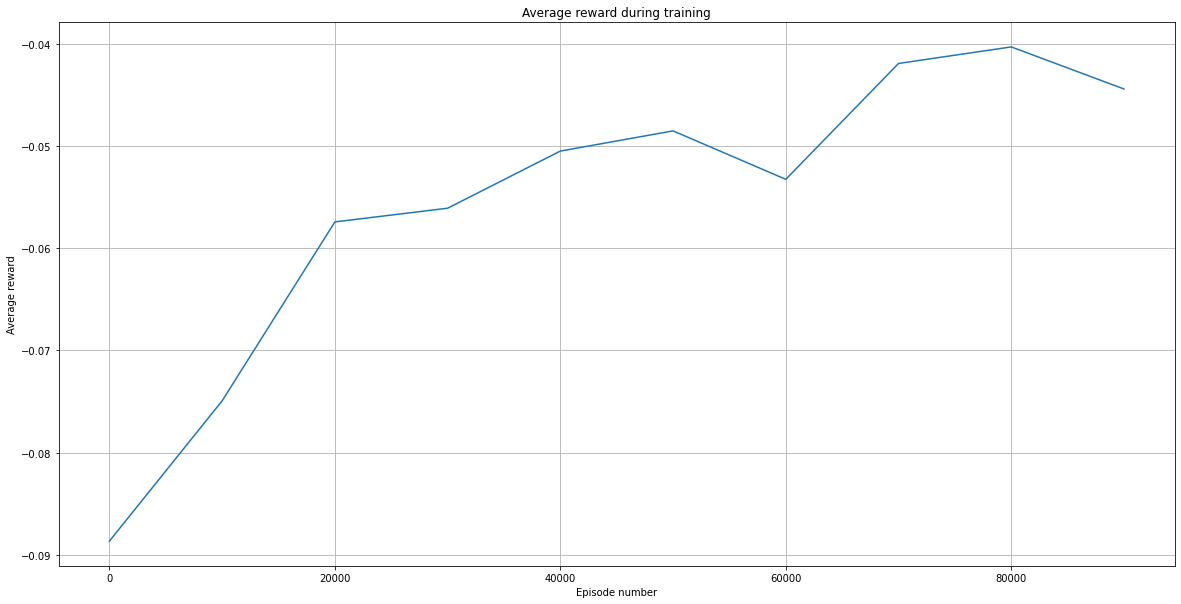

In [24]:
def plot(env, alpha=0.0040, epsilon=0.0500, gamma=0.05, train_episodes=400000):
    dump_reward_every = (int)(train_episodes/10)  
    _, _, rewards = q_learning(
        env=env,
        alpha=alpha,
        epsilon=epsilon,
        gamma=gamma,
        episodes=train_episodes,
        dump_reward_every=dump_reward_every
    )
    plt.figure(figsize=(20, 10))
    plt.plot(range(1, train_episodes, dump_reward_every), rewards)
    plt.title('Average reward during training')
    plt.xlabel('Episode number')
    plt.ylabel('Average reward')
    plt.grid()

plot(env=make_env())